In [1]:
# import library pandas
import pandas as pd
# Import library numpy
import numpy as np
# Import library matplotlib dan seaborn untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import os
from IPython.display import Image
# me-non aktifkan peringatan pada python
import warnings 
warnings.filterwarnings('ignore')
#Metrics
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
# Import Library Confussion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score,roc_auc_score,roc_curve
#Model Select
from sklearn.model_selection import KFold,train_test_split,cross_val_score
# Import Library Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

In [67]:
#memanggil file
df = pd.read_excel('data skripsi coding.xlsx')
df

,no RM,usia,jenis kelamin,hipertensi,DM,merokok,meninggal
0,141037,77,0,1,1,1,1
1,170047,58,0,0,0,1,0
2,232523,64,0,0,0,1,0
3,280333,71,0,0,0,1,0
4,305452,45,1,0,0,1,0
...,...,...,...,...,...,...,...
240,815825,29,0,1,0,0,0
241,815974,55,0,1,0,1,0
242,816928,81,0,1,0,0,0
243,91553,79,0,0,0,0,1


In [68]:
#menghappus kolom yang tidak digunakan
df=df.drop('no RM', axis=1)
df

,usia,jenis kelamin,hipertensi,DM,merokok,meninggal
0,77,0,1,1,1,1
1,58,0,0,0,1,0
2,64,0,0,0,1,0
3,71,0,0,0,1,0
4,45,1,0,0,1,0
...,...,...,...,...,...,...
240,29,0,1,0,0,0
241,55,0,1,0,1,0
242,81,0,1,0,0,0
243,79,0,0,0,0,1


In [4]:
#mendefinisikan variabel
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [5]:
# split data train dan test dengan function train_test_split() dengan test_size=0.25 
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Random Forest

In [6]:
#tunning parameter dengan k-fold
#membuat parameter grid yang akan dicari
np.random.seed(0)
param_grid = {
    'n_estimators' : [100, 250, 500, 1000]
}
#based model
rf = RandomForestClassifier()
#Grid search Model
GSM = GridSearchCV(estimator = rf, param_grid=param_grid, cv=10, n_jobs = -1, verbose=2)

In [7]:
#k-fold RF
GSM.fit(X_train, y_train)
GSM.best_params_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


{'n_estimators': 1000}

In [8]:
#fungsi model training WRF
def Modeltrain(X_train, y_train, ntree):
    oob_scores = [1-RandomForestClassifier(n_estimators=ntree,max_features='sqrt', 
                                           warm_start=True, bootstrap=True, 
                                           oob_score=True, criterion='gini',n_jobs=-1, 
                                           random_state=42).fit(X_train,y_train).oob_score_]
    return {'oob_score': oob_scores}

In [9]:
#fungsi model testing WRF
def ModelTest(X_train, y_train, X_test, y_test, ntree):
    np.random.seed(123)
    model = RandomForestClassifier(n_estimators=ntree,max_features='sqrt', 
                                   warm_start=True,bootstrap=True, 
                                   oob_score=True, criterion='gini', 
                                   n_jobs=-1, random_state=42).fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    confusionmatrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1score = f1_score(y_test, y_pred, pos_label=0)
    fp_rate = 1-( confusionmatrix[1][1]/(confusionmatrix[1][1]+confusionmatrix[1][0]) )
    auc = (1+recall-fp_rate)/2
    return {'model': model, 'y_pred': y_pred, 'y_pred_proba': y_pred_proba,
            'confusionmatrix': confusionmatrix, 'accuracy': accuracy, 
            'precision': precision, 'recall': recall, 
            'f1score': f1score, 'auc': auc} 

In [10]:
#model training RF
rf = Modeltrain(X_train, y_train, ntree=100)
print('Nilai Kesalahan OOB (Random Forest):', rf['oob_score'])

Nilai Kesalahan OOB (Random Forest): [0.20218579234972678]


In [11]:
#model testing RF
rf_eval = ModelTest(X_train, y_train, X_test, y_test,ntree=100)
print('Confusion Matrix:\n', rf_eval['confusionmatrix'])
print('Accuracy:', rf_eval['accuracy'])
print('Precision:','\n', rf_eval['precision'])
print('Recall:','\n', rf_eval['recall'])
print('F1 Score:','\n', rf_eval['f1score'])
print('AUC Score:', rf_eval['auc'])

Confusion Matrix:
 [[54  3]
 [ 4  1]]
Accuracy: 0.8870967741935484
Precision: 
 0.9310344827586207
Recall: 
 0.9473684210526315
F1 Score: 
 0.9391304347826087
AUC Score: 0.5736842105263157


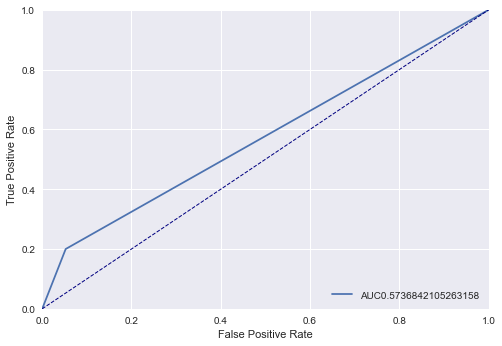

In [12]:
#Grafik ROC RF
roc_auc = roc_auc_score(y_test, rf_eval['y_pred'])
fpr, tpr, _= roc_curve(y_test, rf_eval['y_pred'])
plt.plot(fpr,tpr,label="AUC"+str(roc_auc));
plt.plot([0,1],[0,1], color='navy',lw=1, linestyle='--',)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig("output1.jpg")

In [13]:
#hasil prediksi RF
hasil_rf=pd.DataFrame(y_test,rf_eval['y_pred'])
hasil_rf.to_excel('hasil akhir rf.xlsx')

## Weighted Random Forest

In [14]:
#biaya kesalahan klasifikasi kelas minoritas, cp = 8
#biaya kesalahan klasifikasi kelas mayoritas, cn = 2
wp = 3/(3+4)
wn = 4/(4+3)
print('bobot kelas minoritas : ' ,wp)
print('bobot kelas mayoritas : ' ,wn)

bobot kelas minoritas :  0.42857142857142855
bobot kelas mayoritas :  0.5714285714285714


In [15]:
#fungsi model training WRF
def Modeltrain1(X_train, y_train, ntree, classweight):
    oob_scores1 = [1-RandomForestClassifier(n_estimators=ntree,  class_weight= classweight,
                                            max_features='sqrt',warm_start=True, 
                                            bootstrap=True, oob_score=True, 
                                            criterion='gini', n_jobs=-1, 
                                            random_state=42).fit(X_train,y_train).oob_score_]
    return {'oob_score': oob_scores1}

In [16]:
#fungsi model testing WRF
def ModelTest1(X_train, y_train, X_test, y_test, ntree,classweight):
    np.random.seed(123)
    model1 = RandomForestClassifier(n_estimators=ntree, class_weight=classweight,
                                    max_features='sqrt', warm_start=True,
                                    bootstrap=True, oob_score=True, 
                                    criterion='gini', n_jobs=-1, 
                                    random_state=42).fit(X_train,y_train)
    y_pred1 = model1.predict(X_test)
    y_pred_proba = model1.predict_proba(X_test)[:,1]
    confusionmatrix1 = confusion_matrix(y_test, y_pred1)
    accuracy1 = accuracy_score(y_test, y_pred1)
    precision1 = precision_score(y_test, y_pred1, pos_label=0)
    recall1 = recall_score(y_test, y_pred1, pos_label=0)
    f1score1 = f1_score(y_test, y_pred1, pos_label=0)
    fp_rate1 = 1-( confusionmatrix1[1][1]/(confusionmatrix1[1][1]+confusionmatrix1[1][0]) )
    auc1 = (1+recall1-fp_rate1)/2
    return {'model1': model1, 'y_pred1': y_pred1, 'y_pred_proba': y_pred_proba,
            'confusionmatrix1': confusionmatrix1,'accuracy1': accuracy1, 
            'precision1': precision1,'recall1': recall1,'f1score1': f1score1,'auc1': auc1} 

In [17]:
#tunning parameter dengan k-fold untuk WRF
#membuat parameter grid yang akan dicari
np.random.seed(0)
param_grid2 = {
    'n_estimators' : [100, 250, 500, 1000]
}
#based model
rf = RandomForestClassifier()
#Grid search Model
GSM1 = GridSearchCV(estimator = rf, param_grid=param_grid2, cv=10, n_jobs = -1, verbose=2)

In [18]:
#k-fold WRF
GSM1.fit(X_train, y_train)
GSM1.best_params_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


{'n_estimators': 500}

In [19]:
#model training WRF
wrf = Modeltrain1(X_train, y_train, ntree=100,classweight={0:0.43,1:0.57})
print('Nilai Kesalahan OOB (Random Forest):', wrf['oob_score'])

Nilai Kesalahan OOB (Random Forest): [0.20765027322404372]


In [20]:
#model testing WRF
wrf_eval = ModelTest1(X_train, y_train, X_test, y_test, ntree=100,classweight={0:0.43,1:0.57})
print('Confusion Matrix1:\n', wrf_eval['confusionmatrix1'])
print('Accuracy1:', wrf_eval['accuracy1'])
print('Precision1:','\n', wrf_eval['precision1'])
print('Recall1:','\n', wrf_eval['recall1'])
print('F1 Score1:','\n', wrf_eval['f1score1'])
print('AUC Score1:', wrf_eval['auc1'])

Confusion Matrix1:
 [[55  2]
 [ 4  1]]
Accuracy1: 0.9032258064516129
Precision1: 
 0.9322033898305084
Recall1: 
 0.9649122807017544
F1 Score1: 
 0.9482758620689654
AUC Score1: 0.5824561403508771


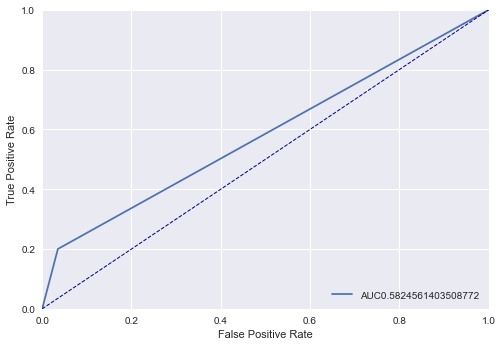

In [21]:
#grafik ROC WRF
roc_auc = roc_auc_score(y_test, wrf_eval['y_pred1'])
fpr, tpr, _= roc_curve(y_test, wrf_eval['y_pred1'])
plt.plot(fpr,tpr,label="AUC"+str(roc_auc));
plt.plot([0,1],[0,1], color='navy',lw=1, linestyle='--',)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig("output2.jpg")

# Ekspor Hasil Prediksi

In [22]:
#hasil prediksi WRF
hasil_wrf=pd.DataFrame(y_test,wrf_eval['y_pred1'])
hasil_wrf.to_excel('hasil akhir wrf.xlsx')

# Variabel Importance

In [24]:
import plotly.express as px

In [72]:
df_importance = pd.DataFrame({'Variabel': df.drop(['meninggal'], axis=1).columns, 'Variabel Importance': rf_eval['model'].feature_importances_})
df_importance.sort_values(by='Variabel Importance',ascending=True,inplace=True)
fig4 = px.bar(df_importance, x='Variabel Importance', y='Variabel',
color='Variabel Importance', labels='Variabel', text='Variabel Importance', height=650)
fig4.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig4.update_layout(uniformtext_minsize=15, uniformtext_mode='hide')
fig4.show()

In [73]:
df_importance = pd.DataFrame({'Variabel': df.drop(['meninggal'], axis=1).columns, 'Variabel Importance': wrf_eval['model1'].feature_importances_})
df_importance.sort_values(by='Variabel Importance',ascending=True,inplace=True)
fig4 = px.bar(df_importance, x='Variabel Importance', y='Variabel',
color='Variabel Importance', labels='Variabel', text='Variabel Importance', height=650)
fig4.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig4.update_layout(uniformtext_minsize=15, uniformtext_mode='hide')
fig4.show()

# Visualisasi Random Forest

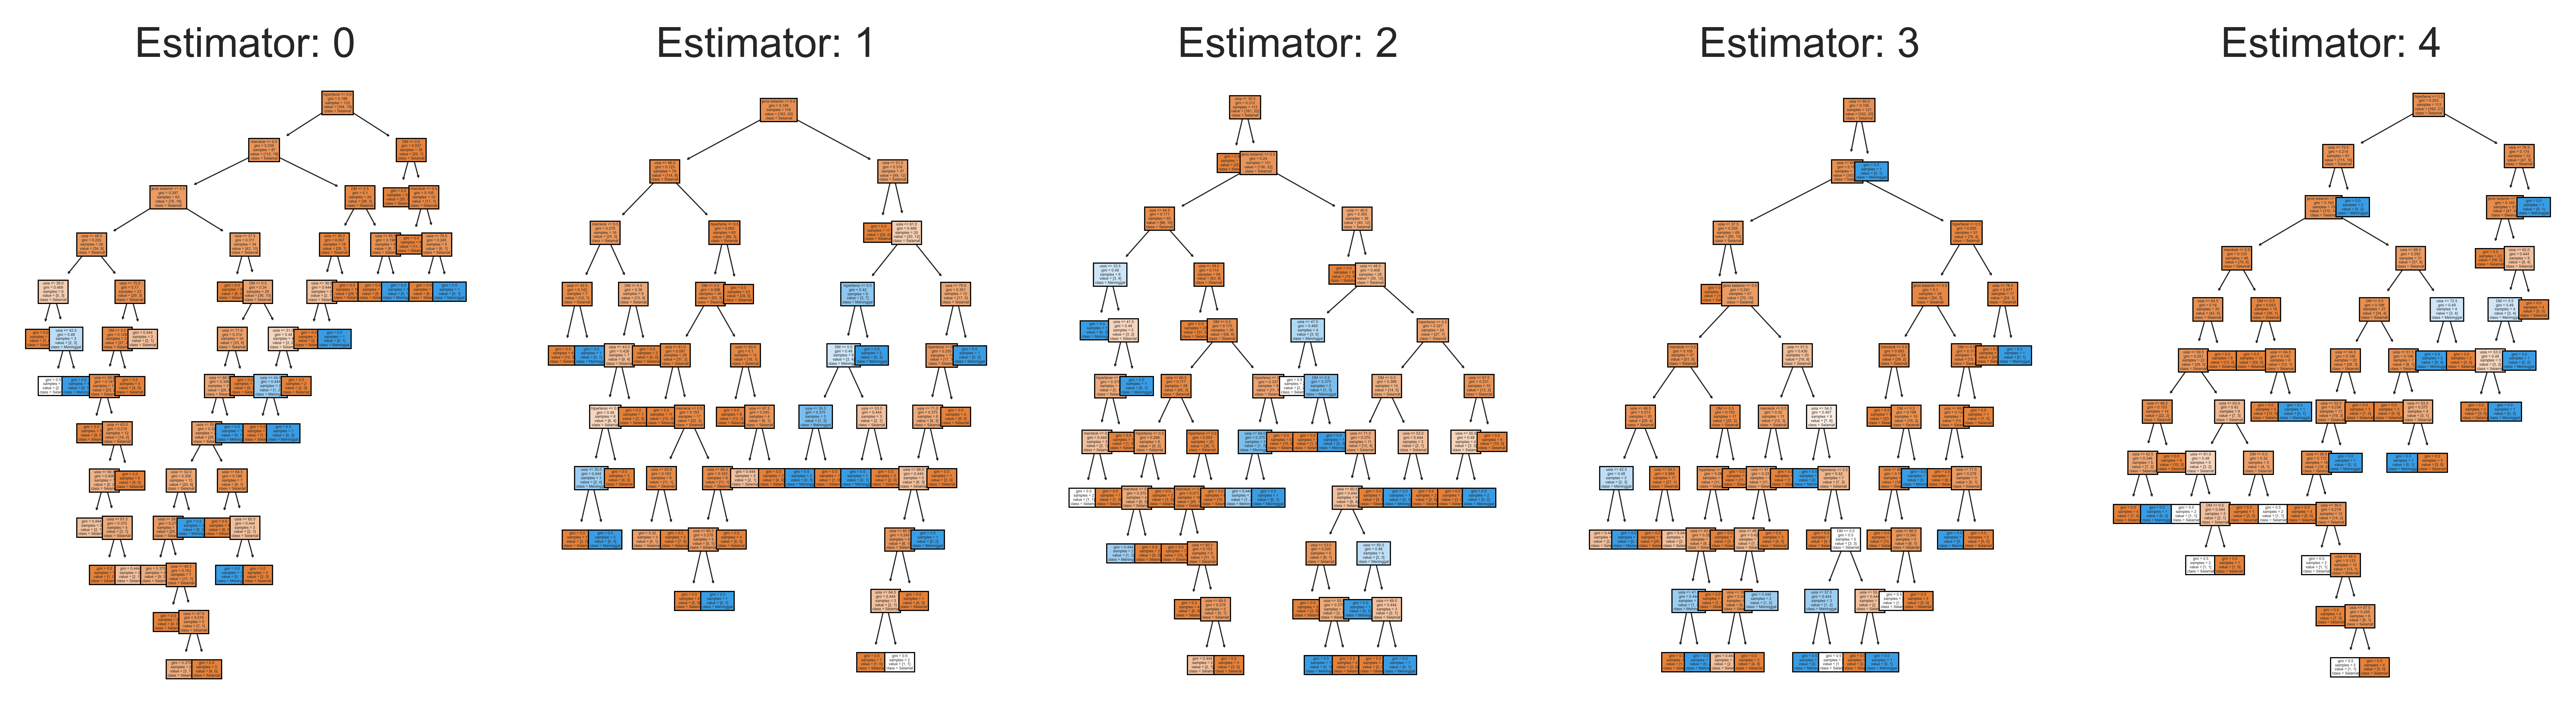

In [29]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (12,3), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf_eval['model'].estimators_[index],
                   feature_names =df.drop(['meninggal'], axis=1).columns,
                   class_names = ['Selamat', 'Meninggal'],
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

# Fungsi Model Prediksi 

In [50]:
#fungsi model prediksi RF
def modelprediksiRF(usia, JK, hipertensi, DM, merokok):
    new=np.array([usia, JK, hipertensi, DM, merokok]).reshape(1,-1)
    model1 = RandomForestClassifier(n_estimators=100,
                                    max_features='sqrt', warm_start=True,
                                    oob_score=True, 
                                    criterion='gini', n_jobs=-1, 
                                    random_state=42).fit(X_train,y_train)
    y_pred1 = model1.predict(new)
    return {'y_pred1': y_pred1} 

In [56]:
hasil=modelprediksiRF(72,0,1,1,1)
hasil

{'y_pred1': array([0], dtype=int64)}

In [51]:
#fungsi model prediksi WRF input data manual
def modelprediksiWRF(usia, JK, hipertensi, DM, merokok):
    baru=np.array([usia, JK, hipertensi, DM, merokok]).reshape(1,-1)
    model1 = RandomForestClassifier(n_estimators=100, class_weight={0:0.43,1:0.57},
                                    max_features='sqrt', warm_start=True,
                                    oob_score=True, 
                                    criterion='gini', n_jobs=-1, 
                                    random_state=42).fit(X_train,y_train)
    y_pred1 = model1.predict(baru)
    return {'y_pred1': y_pred1} 

In [55]:
hasil1=modelprediksiWRF(72,0,1,1,1)
hasil1

{'y_pred1': array([0], dtype=int64)}

In [52]:
#fungsi model testing WRF input data bentuk data frame
def Prediksi(X_test):
    model1 = RandomForestClassifier(n_estimators=100, class_weight={0:0.43,1:0.57},
                                    max_features='sqrt', warm_start=True,
                                    oob_score=True, 
                                    criterion='gini', n_jobs=-1, 
                                    random_state=42).fit(X_train,y_train)
    y_pred1 = model1.predict(X_test)
    return {'model1': model1, 'y_pred1': y_pred1}

In [53]:
data = pd.read_excel('databaru.xlsx')
data

,Usia,Jenis Kelamin,Hipertensi,DM,Merokok
0,62,1,1,1,1
1,38,0,1,1,1
2,70,1,0,1,1
3,67,0,0,1,1
4,47,1,1,0,1
5,35,0,1,0,1
6,51,1,0,0,1
7,70,0,0,0,1
8,82,1,1,1,0
9,38,0,1,1,0


In [54]:
prediksi = Prediksi(data)
prediksi['y_pred1']

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int64)